In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
import time

In [2]:
comments_df = pd.read_csv('../influence__2024-01-09_2024-02-07.csv')
comments_df = comments_df.drop_duplicates()
comments_df.shape

(3626, 17)

In [3]:
influence_df = comments_df[comments_df['resolution'] == 1]
influence_df_text = influence_df['comment_text'].drop_duplicates()
influence_df_text.shape

(407,)

In [6]:
comments = influence_df_text.replace(r'(?s)^(.*?)(\n\n\n|\n\n)', '', regex=True).to_list()

In [26]:
prompt_header = """
You will categorize and summarize GitHub pull request review comments based on software issues they address. You will handle various software issues such as memory management, system calls, code documentation, and others. You should output the results in JSON format, which includes the identified software issue type, and a brief description containing no more than five words.
Example:
Input:
["The function is dereferencing a null pointer", "We need better documentation for this function","The open() system call requires error checking"]
Output: [{"type": "memory management", "summary": "Dereferencing null pointer" },
{ "type": "code documentation", "summary": "Poor function documentation" }, 
{ "type": "system calls", "summary": "Missing error checking in open()" }]

Real input starts here:
"""

In [41]:
SERVER = "https://llm-api.amd.com/azure"
HEADERS = {"Ocp-Apim-Subscription-Key": "924eba03776f40b6b93dfa02b1077098"}

def get_completion(prompt):
    # Set up req body and deployment id
    body = {"messages": [{"role": "user", "content": prompt},],
        "temperature": 0,
        "n": 1,
        "stop": None,
    }
    deployment_id = "swe-gpt4-32k-exp1"
    response = requests.post(url=f"{SERVER}/engines/{deployment_id}/chat/completions", 
                            json=body,
                            headers=HEADERS)
    response.raise_for_status()
    return response.json()

In [77]:
def process_batch(batch, prompt_header):
    prompt = prompt_header + str(batch)
    response = get_completion(prompt)
    return response['choices'][0]['message']['content']

data = []
batch_size = 30
starting_index = 160  # Customize this value for the starting index
num_batches = (len(comments) - starting_index) // batch_size

for i in range(num_batches):
    start = starting_index + i * batch_size
    end = starting_index + (i + 1) * batch_size
    current_batch = comments[start:end]
    result = process_batch(current_batch, prompt_header)
    data.append(result)
    if i < num_batches - 1:
        time.sleep(60)

HTTPError: 504 Server Error: Gateway Time-out for url: https://llm-api.amd.com/azure/engines/swe-gpt4-32k-exp1/chat/completions

In [78]:
data

[]

In [66]:
import json

dfs = []
for i in data:
    dfs.append(pd.read_json(json.loads(i)))

In [74]:
df = pd.read_json('output.json')
df

type                                   summary
0     code readability                  Deeply nested conditions
1     code readability                     Complex if conditions
2     code readability      Deeply nested loops and conditionals
3     code readability      Deeply nested loops and conditionals
4    memory management                 Potential buffer overflow
..                 ...                                       ...
171     error handling       No check for xrs_alloc return value
172   code improvement          Repetition of same block of code
173     error handling  Potential AttributeError in except block
174     error handling  Potential AttributeError in except block
175     error handling                 Assumption of list length

[176 rows x 2 columns]

In [80]:
df['type'].unique()

array(['code readability', 'memory management', 'code documentation',
       'error handling', 'code implementation', 'variable initialization',
       'data type mismatch', 'code structure', 'function call',
       'null pointer dereference', 'data type casting', 'variable scope',
       'preprocessor directives', 'function call order',
       'unused variables', 'thread safety', 'magic numbers',
       'code redundancy', 'recursion', 'scaling factors',
       'undefined variables', 'logical operators', 'system calls',
       'code improvement'], dtype=object)

<Axes: xlabel='type'>

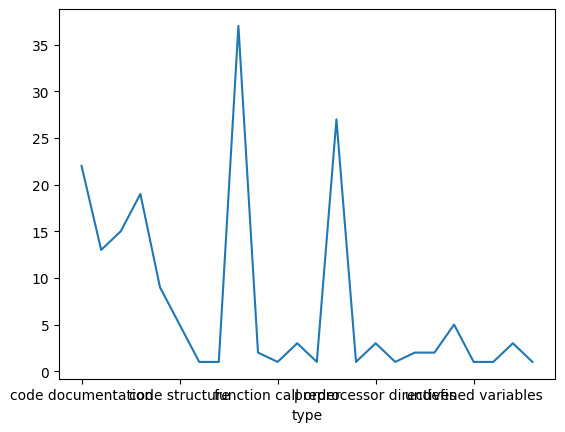

In [82]:
df.groupby('type').size().plot()

In [83]:
def map_issue_to_group(issue):
    groups = {
        'Crashes': ['memory management', 'null pointer dereference'],
        'Unexpected Errors': ['system calls', 'error handling', 'data type mismatch', 'data type casting',
                              'preprocessor directives', 'logical operators', 'undefined variables'],
        'Unpredictable Behavior': ['function call', 'function call order', 'variable initialization', 'variable scope'],
        'Performance Issues': ['code redundancy', 'recursion', 'thread safety', 'scaling factors'],
        'Security Vulnerabilities': ['code implementation'],
        'Difficulties in Maintenance and Understanding': ['code readability', 'code documentation', 'code structure',
                                                          'magic numbers', 'unused variables', 'code improvement']
    }
    
    for group, issues in groups.items():
        if issue in issues:
            return group
    return 'Unknown'

In [84]:
df['consequence_group'] = df['type'].apply(map_issue_to_group)

In [93]:
# Group the issues by their consequence-based groups
grouped_issues = df.groupby('consequence_group').size().reset_index(name='count')

# Calculate the total number of issues
total_issues = grouped_issues['count'].sum()

# Calculate the percentage of the issues in each group
grouped_issues['percentage'] = round((grouped_issues['count'] / total_issues) * 100)

# Sort the table based on the percentage of issues in each group
grouped_issues = grouped_issues.sort_values(by='percentage', ascending=False)

# Reset the index for better presentation
grouped_issues.reset_index(drop=True, inplace=True)

# Display the summary table with percentages
grouped_issues[['consequence_group', 'percentage']]

consequence_group  percentage
0  Difficulties in Maintenance and Understanding        36.0
1                              Unexpected Errors        27.0
2                                        Crashes        16.0
3                             Performance Issues        10.0
4                       Security Vulnerabilities         7.0
5                         Unpredictable Behavior         4.0